# Analysis on Ecological Footprint

## Idea and Conception

###  Understanding the drivers of Biological Footprint using National Footprint Accounts and UN Energy data

Global Footprint Network, founded in 2003, is an independent think tank originally based in the United States, Belgium and Switzerland. It was established as a charitable not-for-profit organization in each of those three countries.

Global Footprint Network develops and promotes tools for advancing sustainability, including the ecological footprint and biocapacity, which measure the amount of resources we use and how much we have. These tools aim at bringing ecological limits to the center of decision-making.

The purpose of this notebook is to do an EDA of the data provided from NFA and merge it with World Bank Data.


# Table of Contents

1. [Data Sourcing and Wrangling](#one)

    1.1 [Creating a function for scale naming](#onea)
    
    1.2 [Loading and Wrangling NFA Data Set](#oneb)
    
    1.3 [Loading and Wrangling UN Data Set](#onec)
    
    
2. [Analysis on Biocapacity and Footprint](#two)

    2.1 [Relationship of biocapacity and ecological footprint over time](#twoa)
    
    2.2 [Ecological debtors and creditors over time](#twob)
    
    2.3 [Ecological Footprint and Biocapacity over time](#twoc)
    
    2.4 [Creating a world map of ecological deficits and reserves](#twod)
    

3. [A closer look at CO2 emissions](#three)

    3.1 [Calculating CO2 emissions by sector](#threea)
    
    3.2 [Correlation Matrix](#threeb)
    
    3.3 [Relationship CO2 per Capita and GDP per Capita](#threec)
    
    3.4 [Energy Production by Type](#threed)

## 1. Data Sourcing and Wrangling
<a id="one"></a>

In [1013]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import figure
import seaborn as sns
import geopandas as gpd
import urllib.request
import zipfile
from zipfile import ZipFile
import requests
import io
import json
import matplotlib.ticker as ticker


%matplotlib inline
random.seed(42)
print('success')

success


### a, Creating a function for cool scales
<a id="onea"></a>

In [1014]:
#just a semi-cool function to get proper scales:

def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["bn", "mn", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

    return y

### b, Loading and Wrangling NFA Data Set
<a id="oneb"></a>

In [1015]:
nfa = pd.read_csv('NFA_2018.csv')
nfa.head()

,country,ISO alpha-3 code,UN_region,UN_subregion,year,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,Percapita GDP (2010 USD),population
0,Armenia,ARM,Asia,Western Asia,1992,BiocapPerCap,1.611286e-01,0.135023,0.083836,0.013718,0.033669,0.000000e+00,4.273741e-01,949.033,3449000
1,Armenia,ARM,Asia,Western Asia,1992,BiocapTotGHA,5.558130e+05,465763.337400,289190.662300,47320.224590,116139.598200,0.000000e+00,1.474227e+06,949.033,3449000
2,Armenia,ARM,Asia,Western Asia,1992,EFConsPerCap,3.909225e-01,0.189137,0.000001,0.004138,0.033669,1.112225e+00,1.730092e+00,949.033,3449000
3,Armenia,ARM,Asia,Western Asia,1992,EFConsTotGHA,1.348487e+06,652429.066600,4.327841,14272.803690,116139.598200,3.836620e+06,5.967954e+06,949.033,3449000
4,Armenia,ARM,Asia,Western Asia,1992,EFExportsPerCap,1.124910e-03,0.002283,0.000000,0.000438,0.000000,4.819043e-02,5.203676e-02,949.033,3449000


The individual country data is aggregated to World again which needs to be omitted from the data set

In [1016]:
nfa_country = nfa.query('country != "World"')
nfa_world = nfa.query('country == "World"')

In [1017]:
nfa_country.shape

(86480, 15)

In [1018]:
nfa_world.shape

(540, 15)

In [1019]:
nfa_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86480 entries, 0 to 87019
Data columns (total 15 columns):
country                     86480 non-null object
ISO alpha-3 code            85660 non-null object
UN_region                   86480 non-null object
UN_subregion                86480 non-null object
year                        86480 non-null int64
record                      86480 non-null object
crop_land                   62990 non-null float64
grazing_land                62990 non-null float64
forest_land                 62990 non-null float64
fishing_ground              62990 non-null float64
built_up_land               62990 non-null float64
carbon                      62990 non-null float64
total                       86480 non-null float64
Percapita GDP (2010 USD)    70870 non-null float64
population                  86480 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 10.6+ MB


**A few countries have total values but those are not broken down by lever (crop_land etc). Watch out when aggregating**

In [1020]:
nfa_country[nfa_country.iloc[:,6:11].isna().any(axis=1)].head()

,country,ISO alpha-3 code,UN_region,UN_subregion,year,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,Percapita GDP (2010 USD),population
1310,Algeria,DZA,Africa,Northern Africa,1961,BiocapPerCap,NaN,NaN,NaN,NaN,NaN,NaN,1.445786e+00,2078.22,11405000
1311,Algeria,DZA,Africa,Northern Africa,1961,BiocapTotGHA,NaN,NaN,NaN,NaN,NaN,NaN,1.648904e+07,2078.22,11405000
1312,Algeria,DZA,Africa,Northern Africa,1961,EFConsPerCap,NaN,NaN,NaN,NaN,NaN,NaN,7.360894e-01,2078.22,11405000
1313,Algeria,DZA,Africa,Northern Africa,1961,EFConsTotGHA,NaN,NaN,NaN,NaN,NaN,NaN,8.395027e+06,2078.22,11405000
1314,Algeria,DZA,Africa,Northern Africa,1961,EFExportsPerCap,NaN,NaN,NaN,NaN,NaN,NaN,1.472014e-01,2078.22,11405000


### c, Loading and wrangling World Bank Data
<a id="onec"></a>

**Dropping unnecessary columns, pivoting and melting the dataset**<br><br>
In order to get a tidy dataset data is cleaned and re-shaped in a way that:
>each variable is a column

>each observation is a row

>each type of observational unit is a table


In [1021]:
df2 = pd.read_csv('world_bank.csv')

In [1022]:
df2.head()

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
0,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Afghanistan,AFG,..,..,..,..,..,..,...,20.68,22.33,24.08,26.17,27.99,30.1,32.44,..,..,..
1,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Albania,ALB,..,..,..,..,..,..,...,65.23,67.81,69.96,71.78,73.98,75.37,77.42,..,..,..
2,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Algeria,DZA,..,..,..,..,..,..,...,92.41,92.49,92.47,92.83,93.1,92.7,92.62,..,..,..
3,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,American Samoa,ASM,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Andorra,AND,..,..,..,..,..,..,...,100,100,100,100,100,100,100,..,..,..


Replacing missing data of .. format with np Nans

In [1023]:
df2.iloc[:,4:].replace('..', np.NaN,inplace=True)

/Users/felixkoehler/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [1024]:
df2.head()

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
0,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,...,20.68,22.33,24.08,26.17,27.99,30.1,32.44,NaN,NaN,NaN
1,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,65.23,67.81,69.96,71.78,73.98,75.37,77.42,NaN,NaN,NaN
2,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,...,92.41,92.49,92.47,92.83,93.1,92.7,92.62,NaN,NaN,NaN
3,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,100,100,100,100,100,100,100,NaN,NaN,NaN


Cleaning all columns with year to have a proper YYYY format

In [1025]:
old_cols = list(df2.iloc[:,4:])
new_cols = list(df2.iloc[:,4:].columns.str[0:4])

In [1026]:
df2.rename(columns=dict(zip(old_cols, new_cols)),inplace=True)

In [1027]:
df2.rename(columns={'Series Name': 'series','Country Name': 'country','Country Code': 'country_code'}, inplace=True)


In [1028]:
df2.drop('Series Code', axis=1,inplace=True)

Melting the data

In [1029]:
df2 = df2.melt(id_vars=['series','country','country_code'], var_name='year', value_name='value')

In [1030]:
df2.tail()

,series,country,country_code,year,value
253735,NaN,NaN,NaN,2019,NaN
253736,NaN,NaN,NaN,2019,NaN
253737,NaN,NaN,NaN,2019,NaN
253738,Data from database: World Development Indicators,NaN,NaN,2019,NaN
253739,Last Updated: 02/27/2020,NaN,NaN,2019,NaN


Casting to int and floats

In [1031]:
df2.year = df2.year.astype(int)

In [1032]:
df2.value = df2.value.astype(float)

In [1033]:
list(df2.series.unique())

['Access to clean fuels and technologies for cooking (% of population)',
 'CO2 emissions (kt)',
 'CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
 'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
 'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
 'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
 'CO2 emissions from transport (% of total fuel combustion)',
 'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2011 PPP)',
 'GDP per capita, PPP (constant 2011 international $)',
 'Electricity production from coal sources (% of total)',
 'Electricity production from hydroelectric sources (% of total)',
 'Electricity production from natural gas sources (% of total)',
 'Electricity production from nuclear sources (% of total)',
 'Electricity production from oil 

After 2014 there is a sharp decline in the availability of values (many Nans). Hence data is cut off from 2015 onwards

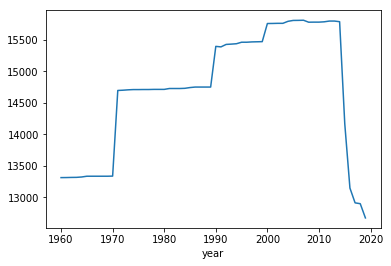

In [1034]:
df2.groupby('year').count().sum(axis=1).plot()

In [1035]:
df2 = df2.query('year < 2015')

In [1036]:
df2 = pd.pivot_table(df2, index=['country','country_code','year'], values='value',columns='series').reset_index()

Calculating CO2 emission values per sector by multiplying the sector percentaged with overall CO2 emissions

In [1037]:
df2[['CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
          'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
          'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from transport (% of total fuel combustion)']] = df2[['CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
          'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
          'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from transport (% of total fuel combustion)']] / 100 #convert to percentage

In [1038]:
df2[['CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
          'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
          'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from transport (% of total fuel combustion)']] = df2[['CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
          'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
          'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
          'CO2 emissions from transport (% of total fuel combustion)']].multiply(df2['CO2 emissions (kt)']*1000, axis="index")

In [1039]:
df2.rename(columns={
    'CO2 emissions from electricity and heat production, total (% of total fuel combustion)':'CO2 electricity and heat production (t)',
    'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)':'CO2 from manufacturing industries and construction (t)',
    'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)':'CO2 from other sectors, excluding residential buildings and commercial and public services (t)',
    'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)':'CO2 from residential buildings and commercial and public services (t)',
    'CO2 emissions from transport (% of total fuel combustion)':'CO2 from transport (t)'},
                inplace=True)

In [1040]:
df2.sample(5)

series,country,country_code,year,Access to clean fuels and technologies for cooking (% of population),CO2 emissions (kt),CO2 electricity and heat production (t),CO2 from manufacturing industries and construction (t),"CO2 from other sectors, excluding residential buildings and commercial and public services (t)",CO2 from residential buildings and commercial and public services (t),CO2 from transport (t),Electric power consumption (kWh per capita),Electricity production from coal sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from natural gas sources (% of total),Electricity production from nuclear sources (% of total),Electricity production from oil sources (% of total),"Electricity production from renewable sources, excluding hydroelectric (% of total)","Energy use (kg of oil equivalent) per $1,000 GDP (constant 2011 PPP)","GDP per capita, PPP (constant 2011 international $)"
8761,Norway,NOR,1960,NaN,13102.191,2.316298e+05,4.954864e+06,3.031329e+06,1.248787e+06,3.635581e+06,7681.140521,0.000000,99.300343,0.000000,0.000000,0.699657,0.0,NaN,NaN
9141,Palau,PLW,2014,85.85,260.357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15326.253914
9695,Qatar,QAT,1993,NaN,30722.126,2.001867e+07,7.102102e+06,0.000000e+00,2.213120e+05,3.359918e+06,10367.333428,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,NaN,NaN
10655,South Asia (IDA & IBRD),TSA,1984,NaN,447627.023,1.477708e+08,1.390308e+08,3.112249e+07,6.022634e+07,6.944330e+07,165.862141,49.416010,34.694853,5.171937,2.175289,7.622661,NaN,NaN,NaN
10307,Slovak Republic,SVK,1995,NaN,42115.495,1.837061e+07,1.066681e+07,6.028176e+05,8.582488e+06,3.872337e+06,4925.961381,26.449221,18.465264,9.009384,43.276071,2.800061,0.0,250.44414,13236.676199


## 2. Analysis on Biocapacity and Footprint
<a id="two"></a>

Preparing Data

In [1041]:
filter_list = ['BiocapTotGHA','EFConsTotGHA']

nfa_year_world = nfa_world[nfa_world.record.isin(filter_list)].groupby(['year','record','country']).agg(
    {'crop_land':'sum','grazing_land':'sum','forest_land':'sum','fishing_ground':'sum',
     'built_up_land':'sum', 'carbon':'sum', 'total':'sum'}).reset_index()
nfa_year_world.year = nfa_year_world.year.astype('str')

#nfa_year_agg = nfa[nfa.record.isin(filter_list)].groupby(['year','record']).total.sum().reset_index()
#nfa_year_agg.year = nfa_year.year.astype('str')


In [1042]:
nfa_year_world.head()

,year,record,country,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total
0,1961,BiocapTotGHA,World,1.428570e+09,1.477750e+09,5.496461e+09,1.127790e+09,80773053.59,0.000000e+00,9.611344e+09
1,1961,EFConsTotGHA,World,1.428570e+09,8.163944e+08,1.324172e+09,2.940839e+08,80773053.59,3.091250e+09,7.035243e+09
2,1962,BiocapTotGHA,World,1.488693e+09,1.477363e+09,5.491194e+09,1.125151e+09,85478748.67,0.000000e+00,9.667879e+09
3,1962,EFConsTotGHA,World,1.488693e+09,8.237913e+08,1.335109e+09,3.075578e+08,85478748.67,3.225366e+09,7.265996e+09
4,1963,BiocapTotGHA,World,1.506048e+09,1.473457e+09,5.477702e+09,1.121346e+09,87558756.57,0.000000e+00,9.666112e+09


In [1043]:
#nfa_year['delta'] = (nfa_year.crop_land + nfa_year.grazing_land + nfa_year.forest_land + nfa_year.fishing_ground + nfa_year.built_up_land + nfa_year.carbon) - nfa_year.total

In [1044]:
nfa_test = pd.pivot_table(nfa_year_world, values = 'total', index='year', columns = 'record').reset_index()
nfa_test.rename(columns={'BiocapTotGHA':'Biocapacity', 'EFConsTotGHA':'Ecological Footprint'},inplace=True)
nfa_test = nfa_test.reset_index()
nfa_test.columns

Index(['index', 'year', 'Biocapacity', 'Ecological Footprint'], dtype='object', name='record')

In [1045]:
nfa_test.head()

record,index,year,Biocapacity,Ecological Footprint
0,0,1961,9.611344e+09,7.035243e+09
1,1,1962,9.667879e+09,7.265996e+09
2,2,1963,9.666112e+09,7.550641e+09
3,3,1964,9.712774e+09,7.864634e+09
4,4,1965,9.736612e+09,8.155050e+09


### a, Relationship of biocapacity and ecological footprint over time
<a id="twoa"></a>

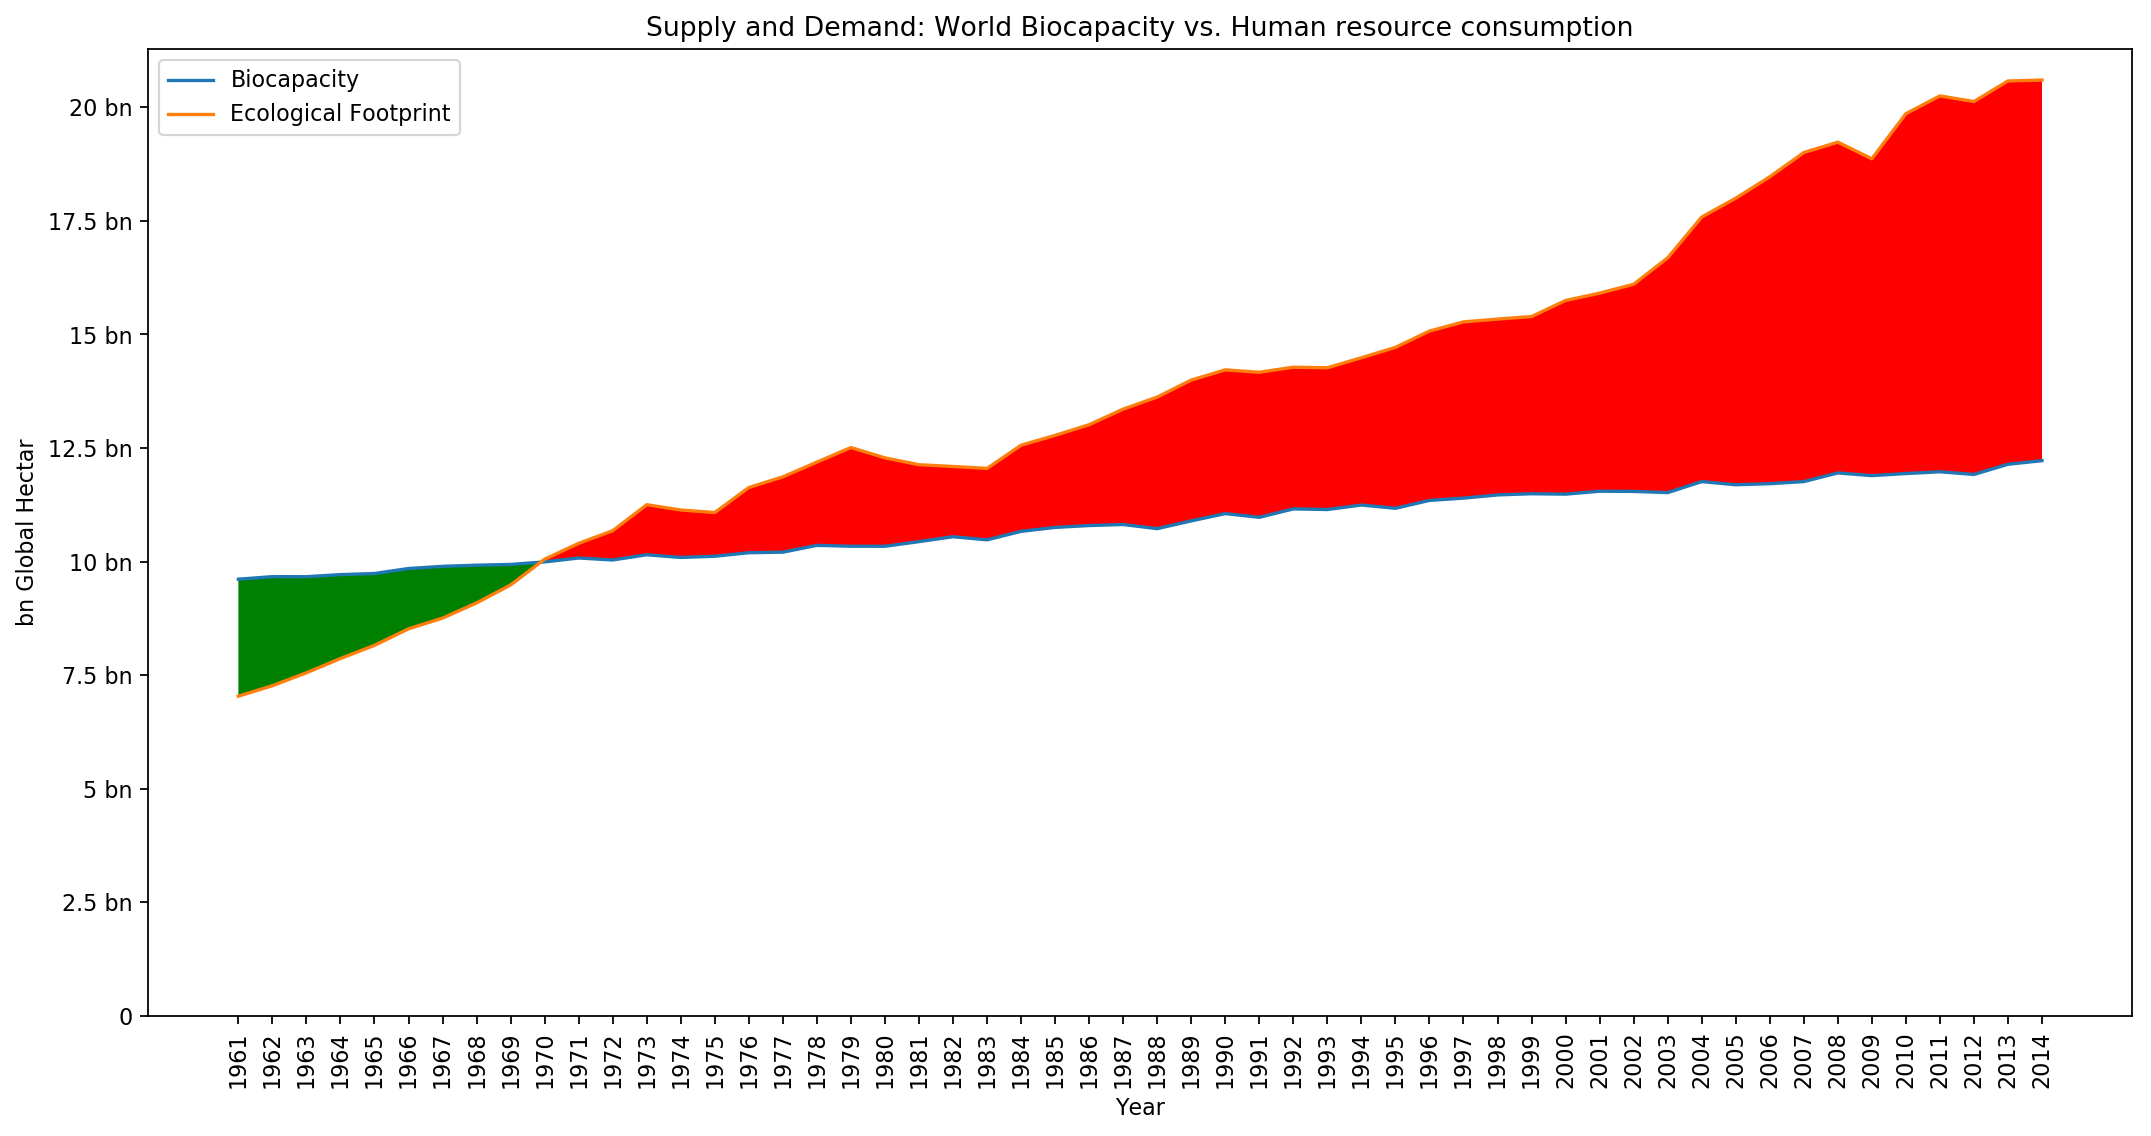

In [1046]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=160)

x = nfa_test['year']
y = nfa_test['Biocapacity']
y2 = nfa_test['Ecological Footprint']

#ax = nfa_test.plot(kind='line', x='year')
ax = sns.lineplot(data = nfa_year_world, x='year',y='total',err_style='bars', hue='record')

ax.fill_between(x, y, y2, where=y >= y2, facecolor='green', interpolate=True)
ax.fill_between(x, y, y2, where=y <= y2, facecolor='red', interpolate=True)
ax.set_title("Supply and Demand: World Biocapacity vs. Human resource consumption")
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax.set_xlabel('Year')
ax.set_ylabel('bn Global Hectar')
ax.legend(['Biocapacity','Ecological Footprint'])
ax.set_ylim(ymin=0)


plt.xticks(rotation=90)
plt.show();


### b, Ecological debtors and creditors over time
<a id="twob"></a>

In [1047]:
filter_list = ['BiocapTotGHA','EFConsTotGHA']

nfa_year_country = nfa_country[nfa.record.isin(filter_list)].groupby(
    ['year','country','ISO alpha-3 code','record','population']).agg(
    {'crop_land':'sum','grazing_land':'sum','forest_land':'sum','fishing_ground':'sum',
     'built_up_land':'sum', 'carbon':'sum', 'total':'sum'}).reset_index()
nfa_year_country.rename(columns={'ISO alpha-3 code':'country_code'},inplace=True)
nfa_year_country = pd.pivot_table(
    nfa_year_country, values = ['crop_land', 'grazing_land', 'forest_land', 'fishing_ground',
                                'built_up_land', 'carbon', 'total'],
    index=['year','country_code','country','population'], 
    columns = 'record').reset_index()
nfa_year_country['delta'] = nfa_year_country.total.BiocapTotGHA - nfa_year_country.total.EFConsTotGHA
nfa_year_country.head()

/Users/felixkoehler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


year country_code      country population built_up_land               \
record                                             BiocapTotGHA EFConsTotGHA   
0       1961          AFG  Afghanistan    9165000   272261.5698  272261.5698   
1       1961          AGO       Angola    5367000   123890.7801  123890.7801   
2       1961          ALB      Albania    1686000    25025.7947   25025.7947   
3       1961          ARG    Argentina   20953000   978338.7683  978338.7683   
4       1961          AUS    Australia   10495000   253377.4579  253377.4579   

             carbon                   crop_land               fishing_ground  \
record BiocapTotGHA  EFConsTotGHA  BiocapTotGHA  EFConsTotGHA   BiocapTotGHA   
0               0.0  2.618627e+05  4.990785e+06  4.938658e+06   0.000000e+00   
1               0.0  1.606666e+05  1.803384e+06  1.270779e+06   5.718206e+06   
2               0.0  8.479414e+05  4.680487e+05  7.637922e+05   2.484018e+05   
3               0.0  1.722027e+07  2.373463e+07  1.566020e+07   7.277170e+07   
4               0.0  3.176018e+07  1.360671e+07  5.525746e+06   7.785166e+07   

                       forest_land                grazing_land                \
record  EFConsTotGHA  BiocapTotGHA  EFConsTotGHA  BiocapTotGHA  EFConsTotGHA   
0       4.853464e+02  6.544311e+05  7.888956e+05  6.212850e+06  4.840614e+06   
1       1.420413e+06  1.404414e+07  8.299598e+05  3.128763e+07  8.848468e+05   
2       5.288525e+03  1.187360e+06  7.772061e+05  8.357058e+05  8.203746e+05   
3       4.342920e+05  3.400692e+07  6.564308e+06  8.647207e+07  3.827847e+07   
4       5.174416e+05  4.873052e+07  1.082225e+07  1.659256e+08  2.952739e+07   

               total                       delta  
record  BiocapTotGHA  EFConsTotGHA                
0       1.213033e+07  1.110278e+07  1.027550e+06  
1       5.297725e+07  4.690555e+06  4.828669e+07  
2       2.764542e+06  3.239629e+06 -4.750870e+05  
3       2.179637e+08  7.913587e+07  1.388278e+08  
4       3.063679e+08  7.840639e+07  2.279615e+08

In [1048]:
nfa_year_country.columns = [' '.join(col).strip() for col in nfa_year_country.columns.values]

In [1049]:
nfa_year_country.columns = nfa_year_country.columns.str.replace(' ', '_')

In [1050]:
nfa_year_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8566 entries, 0 to 8565
Data columns (total 19 columns):
year                           8566 non-null int64
country_code                   8566 non-null object
country                        8566 non-null object
population                     8566 non-null int64
built_up_land_BiocapTotGHA     8566 non-null float64
built_up_land_EFConsTotGHA     8566 non-null float64
carbon_BiocapTotGHA            8566 non-null float64
carbon_EFConsTotGHA            8566 non-null float64
crop_land_BiocapTotGHA         8566 non-null float64
crop_land_EFConsTotGHA         8566 non-null float64
fishing_ground_BiocapTotGHA    8566 non-null float64
fishing_ground_EFConsTotGHA    8566 non-null float64
forest_land_BiocapTotGHA       8566 non-null float64
forest_land_EFConsTotGHA       8566 non-null float64
grazing_land_BiocapTotGHA      8566 non-null float64
grazing_land_EFConsTotGHA      8566 non-null float64
total_BiocapTotGHA             8566 non-null float6

In [1051]:
nfa_year_country['non_overshoot'] = nfa_year_country.delta.apply(lambda x: 1 if x >= 0 else 0)
nfa_year_country['overshoot'] = nfa_year_country.delta.apply(lambda x: 0 if x >= 0 else 1)
nfa_year_country['overshoot_rel'] = (nfa_year_country.total_BiocapTotGHA - nfa_year_country.total_EFConsTotGHA)  / (nfa_year_country.total_BiocapTotGHA)                                                                                                            
nfa_year_country['overshoot_rel_cap'] = nfa_year_country['delta'] / nfa_year_country['population'] 

In [1052]:
nfa_year_country.head()

,year,country_code,country,population,built_up_land_BiocapTotGHA,built_up_land_EFConsTotGHA,carbon_BiocapTotGHA,carbon_EFConsTotGHA,crop_land_BiocapTotGHA,crop_land_EFConsTotGHA,...,forest_land_EFConsTotGHA,grazing_land_BiocapTotGHA,grazing_land_EFConsTotGHA,total_BiocapTotGHA,total_EFConsTotGHA,delta,non_overshoot,overshoot,overshoot_rel,overshoot_rel_cap
0,1961,AFG,Afghanistan,9165000,272261.5698,272261.5698,0.0,2.618627e+05,4.990785e+06,4.938658e+06,...,7.888956e+05,6.212850e+06,4.840614e+06,1.213033e+07,1.110278e+07,1.027550e+06,1,0,0.084709,0.112117
1,1961,AGO,Angola,5367000,123890.7801,123890.7801,0.0,1.606666e+05,1.803384e+06,1.270779e+06,...,8.299598e+05,3.128763e+07,8.848468e+05,5.297725e+07,4.690555e+06,4.828669e+07,1,0,0.911461,8.996962
2,1961,ALB,Albania,1686000,25025.7947,25025.7947,0.0,8.479414e+05,4.680487e+05,7.637922e+05,...,7.772061e+05,8.357058e+05,8.203746e+05,2.764542e+06,3.239629e+06,-4.750870e+05,0,1,-0.171850,-0.281784
3,1961,ARG,Argentina,20953000,978338.7683,978338.7683,0.0,1.722027e+07,2.373463e+07,1.566020e+07,...,6.564308e+06,8.647207e+07,3.827847e+07,2.179637e+08,7.913587e+07,1.388278e+08,1,0,0.636931,6.625676
4,1961,AUS,Australia,10495000,253377.4579,253377.4579,0.0,3.176018e+07,1.360671e+07,5.525746e+06,...,1.082225e+07,1.659256e+08,2.952739e+07,3.063679e+08,7.840639e+07,2.279615e+08,1,0,0.744078,21.720964


In [1053]:
data = nfa_year_country.groupby('year').agg({'non_overshoot':'sum','overshoot':'sum'}).reset_index()

In [1054]:
deltas = nfa_year_country[
    nfa_year_country['year'] == 2014][
    ['country','delta','overshoot_rel','overshoot_rel_cap','built_up_land_BiocapTotGHA',
    'carbon_BiocapTotGHA','crop_land_BiocapTotGHA','fishing_ground_BiocapTotGHA',
    'forest_land_BiocapTotGHA','grazing_land_BiocapTotGHA','total_BiocapTotGHA']].sort_values(by='delta')

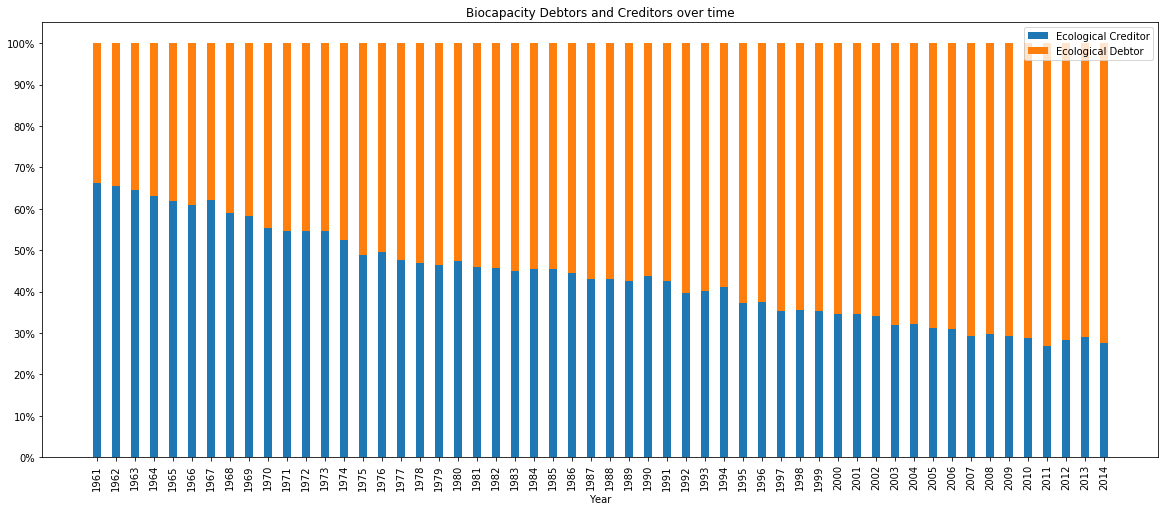

In [1055]:
#figure(num=None, figsize=(16, 8), dpi=160)

data = nfa_year_country.groupby('year').agg({'non_overshoot':'sum','overshoot':'sum'}).reset_index()

N = data.year.nunique()
non_overshoot = data.non_overshoot
overshoot = data.overshoot
ind = np.arange(N)    # the x locations for the groups
width = 0.4
# the width of the bars: can also be len(x) sequence
figure, ax = plt.subplots(figsize=(20,8))

plt.bar(ind, (non_overshoot/(non_overshoot + overshoot)), width)
plt.bar(ind, (overshoot/(non_overshoot + overshoot)), width, bottom = (non_overshoot/(non_overshoot + overshoot)))


plt.xlabel('Year')
plt.title('Biocapacity Debtors and Creditors over time')
plt.xticks(ind, data.year,rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(labels= ['Ecological Creditor','Ecological Debtor'], loc='upper right')


ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Creditors', 'Debtors'))
#plt.figure(figsize=(20,8))

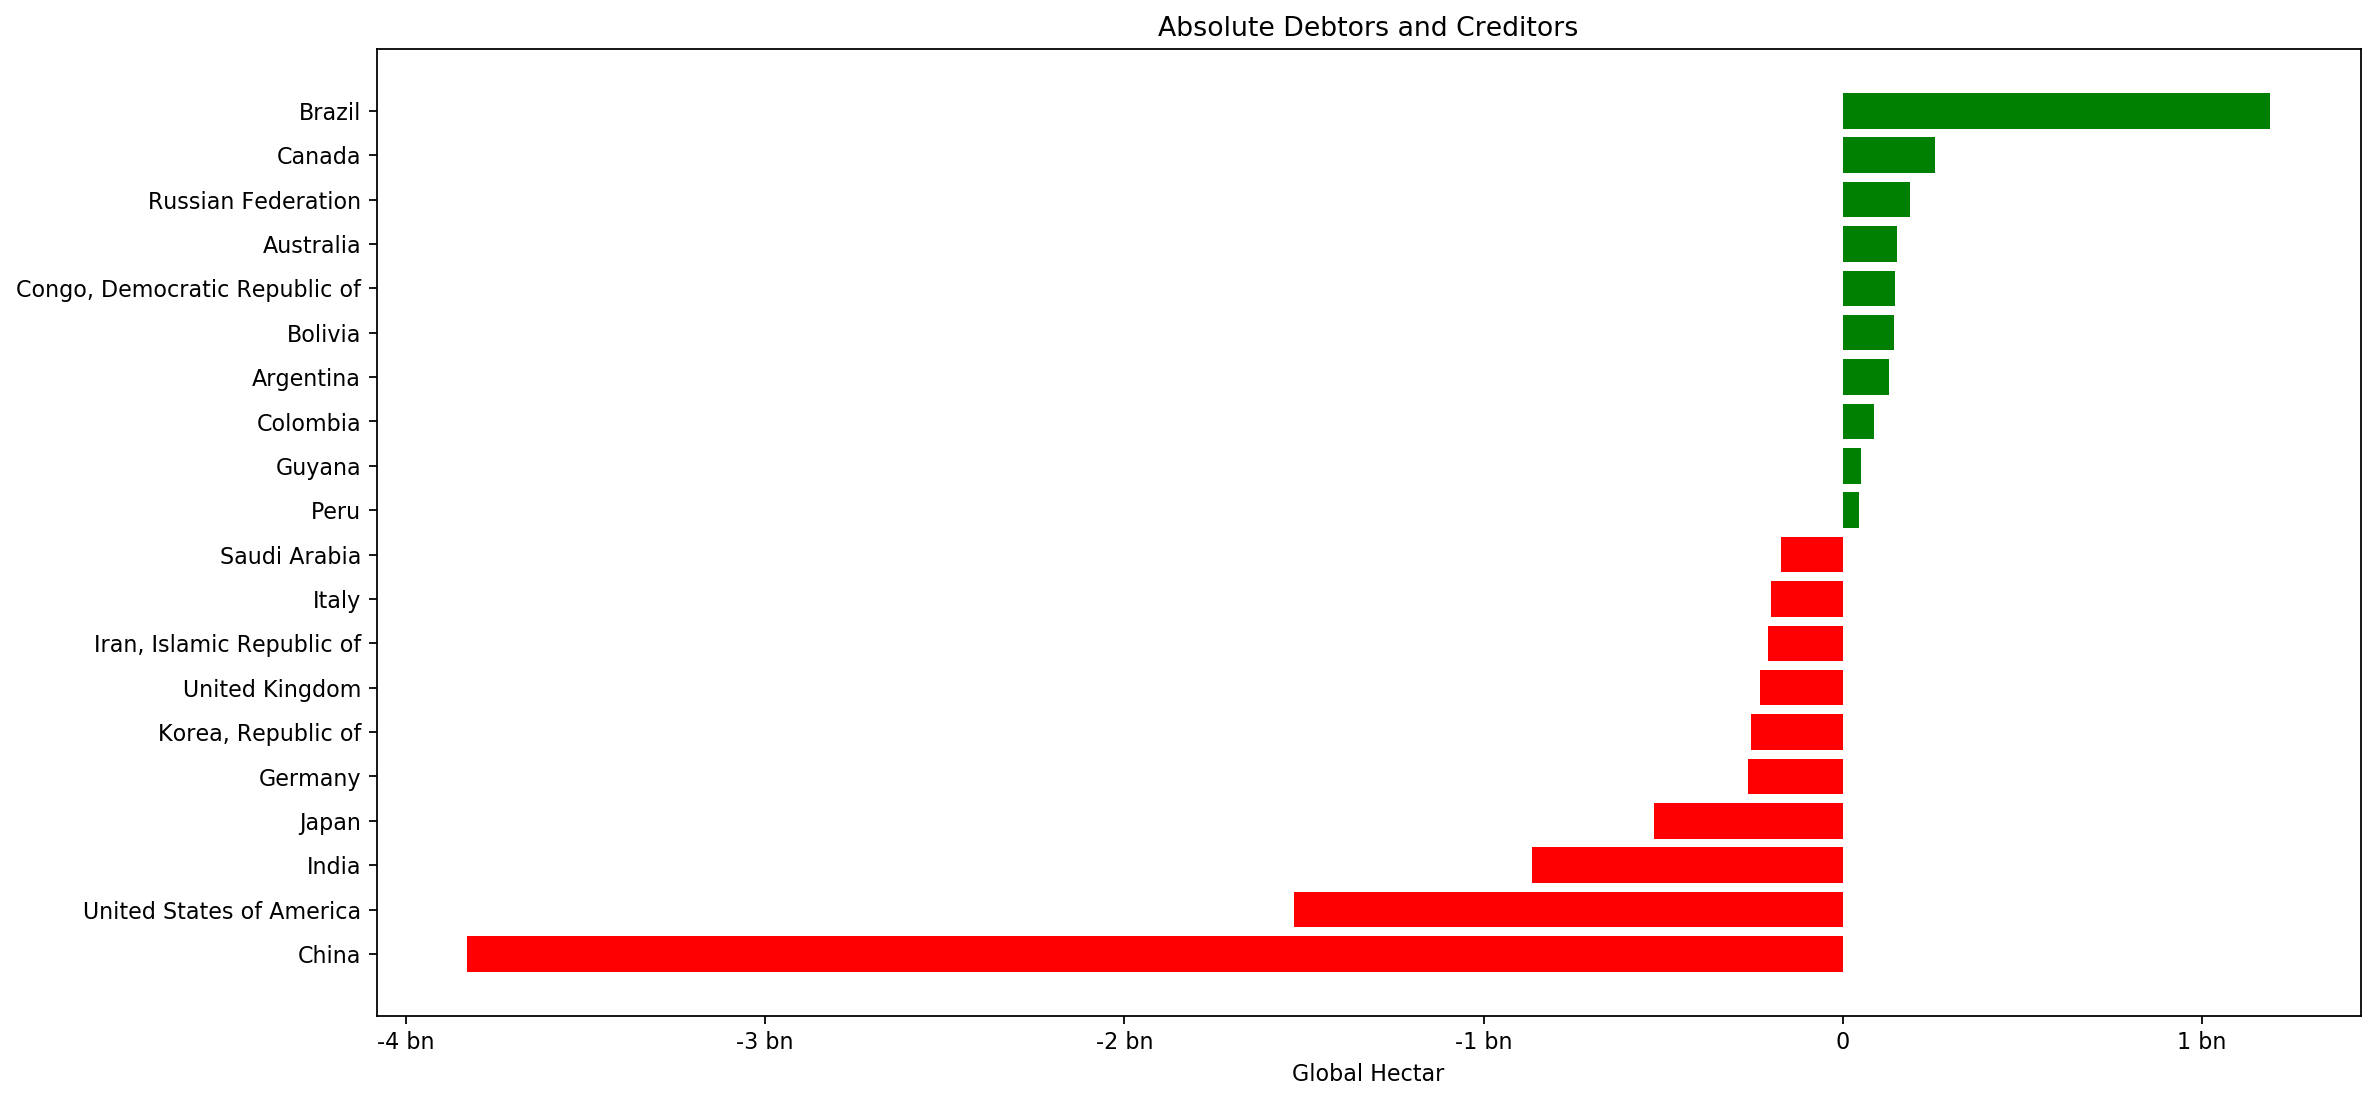

In [1056]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(16, 8), dpi=160)

data = pd.concat([deltas.head(10), deltas.tail(10)])

height = data.delta
bars = data.country
y_pos = np.arange(len(bars))
 
ax = plt.subplot()
plt.barh(y_pos, height,color = (data['delta'] > 0).map({True: 'g',False: 'r'}))
 
plt.yticks(y_pos, bars)
plt.xlabel('Global Hectar')
plt.title('Absolute Debtors and Creditors')
ax.xaxis.set_major_formatter(FuncFormatter(y_fmt))
plt.show()

### c, Ecological Footprint and Biocapacity over time
<a id="twoc"></a>

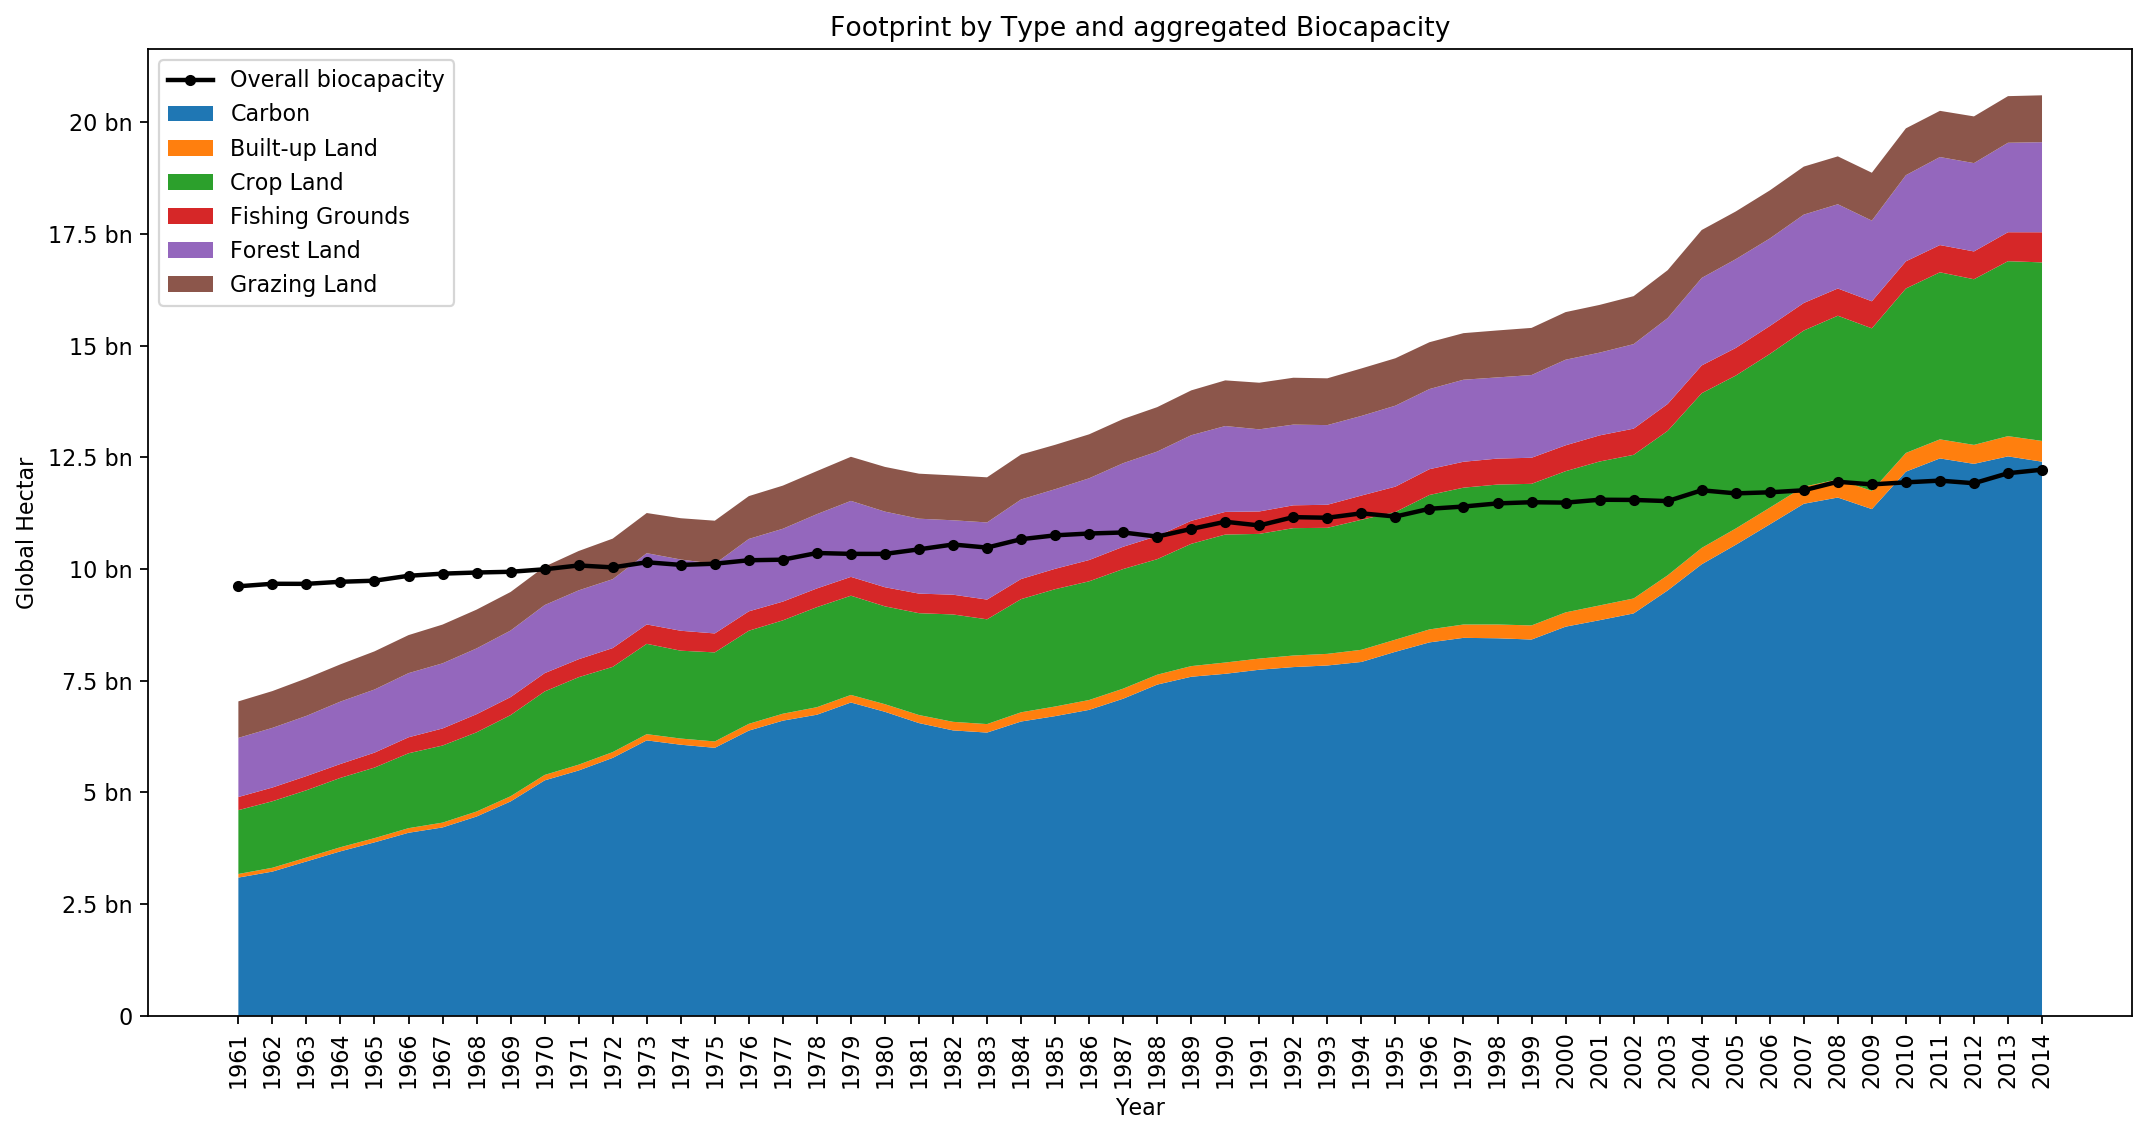

In [1057]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=160)

x= nfa_year_world.year.unique()
#z= [nfa_year.query('record == "BiocapTotGHA"')['carbon'],
#    nfa_year.query('record == "BiocapTotGHA"')['built_up_land'], 
#    nfa_year.query('record == "BiocapTotGHA"')['crop_land'],
#    nfa_year.query('record == "BiocapTotGHA"')['fishing_ground'],
#    nfa_year.query('record == "BiocapTotGHA"')['forest_land'],
#    nfa_year.query('record == "BiocapTotGHA"')['grazing_land']
#   ]

z = list(nfa_world.query('record == "BiocapTotGHA"')['total'])

y = [nfa_world.query('record == "EFConsTotGHA"')['carbon'],
    nfa_world.query('record == "EFConsTotGHA"')['built_up_land'], 
    nfa_world.query('record == "EFConsTotGHA"')['crop_land'],
    nfa_world.query('record == "EFConsTotGHA"')['fishing_ground'],
    nfa_world.query('record == "EFConsTotGHA"')['forest_land'],
    nfa_world.query('record == "EFConsTotGHA"')['grazing_land']
   ]


ax = plt.subplot()
plt.stackplot(x,y, labels=['Carbon','Built-up Land','Crop Land','Fishing Grounds','Forest Land','Grazing Land'])

plt.plot(z,color='black', marker='o',linewidth=2, markersize=4,label='Overall biocapacity')

plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Global Hectar')
plt.title('Footprint by Type and aggregated Biocapacity')
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

ax.set_ylim(ymin=0)

plt.show()


[Text(0,0,'Brazil'),
 Text(0,0,'China'),
 Text(0,0,'United States of America'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'India'),
 Text(0,0,'Canada'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Australia'),
 Text(0,0,'Argentina'),
 Text(0,0,'Congo, Democratic Republic of')]

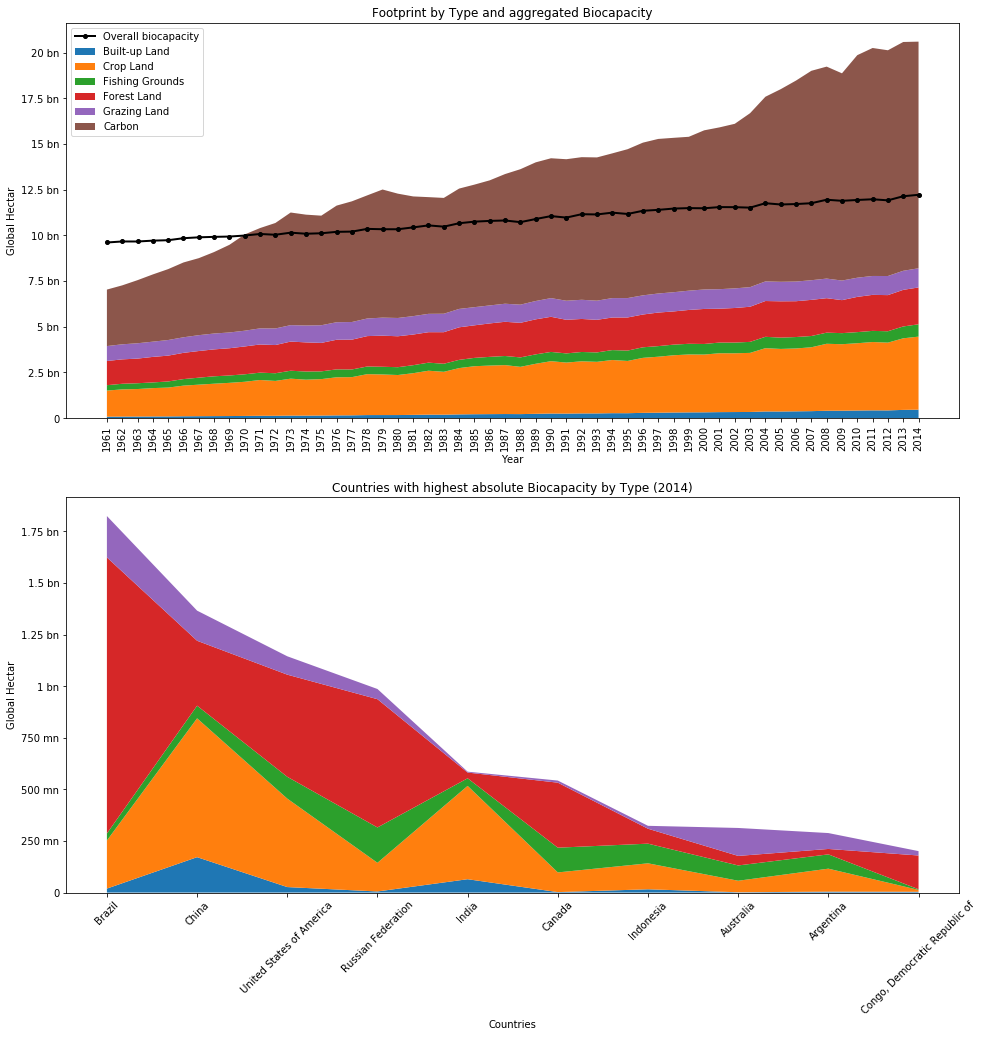

In [1058]:
fig, axs = plt.subplots(2, sharex=False,  sharey=False,figsize = [16,16])
x= nfa_year_world.year.unique()
#z= [nfa_year.query('record == "BiocapTotGHA"')['carbon'],
#    nfa_year.query('record == "BiocapTotGHA"')['built_up_land'], 
#    nfa_year.query('record == "BiocapTotGHA"')['crop_land'],
#    nfa_year.query('record == "BiocapTotGHA"')['fishing_ground'],
#    nfa_year.query('record == "BiocapTotGHA"')['forest_land'],
#    nfa_year.query('record == "BiocapTotGHA"')['grazing_land']
#   ]

z = list(nfa_world.query('record == "BiocapTotGHA"')['total'])

y = [nfa_world.query('record == "EFConsTotGHA"')['built_up_land'], 
    nfa_world.query('record == "EFConsTotGHA"')['crop_land'],
    nfa_world.query('record == "EFConsTotGHA"')['fishing_ground'],
    nfa_world.query('record == "EFConsTotGHA"')['forest_land'],
    nfa_world.query('record == "EFConsTotGHA"')['grazing_land'],
    nfa_world.query('record == "EFConsTotGHA"')['carbon']
   ]

data = deltas.sort_values(by='total_BiocapTotGHA',ascending = False).head(10) 
x1=list(data.country)
y1= list(data.built_up_land_BiocapTotGHA)
y2= list(data.crop_land_BiocapTotGHA)
y3= list(data.fishing_ground_BiocapTotGHA)
y4= list(data.forest_land_BiocapTotGHA)
y5= list(data.grazing_land_BiocapTotGHA)


axs[0].stackplot(x,y, labels=['Built-up Land','Crop Land','Fishing Grounds','Forest Land','Grazing Land','Carbon'])
axs[0].plot(z,color='black', marker='o',linewidth=2, markersize=4,label='Overall biocapacity')
axs[0].yaxis.set_major_formatter(FuncFormatter(y_fmt))#axs[0].set_ylim(ymin=0)
axs[0].legend(loc='upper left')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Global Hectar')
axs[0].set_title('Footprint by Type and aggregated Biocapacity')
axs[0].set_xticklabels(x, rotation=90)


axs[1].stackplot(x1,y1, y2, y3, y4, y5, labels=['Built-up Land','Crop Land','Fishing Ground','Grazing Land','Forest Land'])
axs[1].yaxis.set_major_formatter(FuncFormatter(y_fmt))
axs[1].set_xlabel('Countries')
axs[1].set_ylabel('Global Hectar')
axs[1].set_title('Countries with highest absolute Biocapacity by Type (2014)')
axs[1].set_xticklabels(x1, rotation=45)

### d, Creating a world map of ecological deficits and reserves
<a id="twod"></a>

Downloading necessary shapefiles

In [1059]:
url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['ne_110m_admin_0_countries.dbf', 'ne_110m_admin_0_countries.prj', 'ne_110m_admin_0_countries.shp', 'ne_110m_admin_0_countries.shx']


Joining dataframe with polygon data

In [1060]:
dbf, prj, shp, shx = [filename for filename in filenames]
gdf = gpd.read_file(local_path + shp)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,United Republic of Tanzania,TZA,POLYGON ((33.90371119710453 -0.950000000000000...
2,Western Sahara,SAH,POLYGON ((-8.665589565454809 27.65642588959236...
3,Canada,CAN,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,United States of America,USA,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [1061]:
#print(gdf[gdf['country'] == 'Antarctica'])
#gdf = gdf.drop(gdf.index[159])

In [1062]:
gdf.drop('country',axis=1,inplace=True)

In [1063]:
df_2014 = nfa_year_country[nfa_year_country['year'] == 2014]
df_2014 = df_2014[['country_code','delta','non_overshoot',
                   'overshoot','overshoot_rel','overshoot_rel_cap']]

df_2014 = df_2014.reset_index(level=0)
df_2014.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
index                188 non-null int64
country_code         188 non-null object
delta                188 non-null float64
non_overshoot        188 non-null int64
overshoot            188 non-null int64
overshoot_rel        188 non-null float64
overshoot_rel_cap    188 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 10.4+ KB


In [1064]:
merged = gdf.merge(df_2014, left_on = 'country_code', right_on = 'country_code')
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [1065]:
df_2014 = df_2014[['country_code','overshoot_rel','overshoot_rel_cap']].reset_index()

In [1066]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import export_png


#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['RdYlGn'][8]
#Reverse color order 
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -5, high = 5)
#Define custom tick labels for color bar.
#tick_labels = np.arrange()
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')#, major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Overshooters and Undershooters relatively to their biocapacity in 2014', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'overshoot_rel', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

**Creating a map per capita**

In [1067]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import export_png

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['RdYlGn'][8]
#Reverse color order
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -5, high = 5)
#Define custom tick labels for color bar.
#tick_labels = np.arrange()
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')#, major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Overshooters and Undershooters per capita in 2014', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'overshoot_rel_cap', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
#output_notebook()
#export_png(plot, filename="capita.png")
#Display figure.
show(p)

## 3, A closer look at CO2 emissions 
<a id="three"></a>

### a, Calculating CO2 emissions by sector
<a id="threea"></a>

''

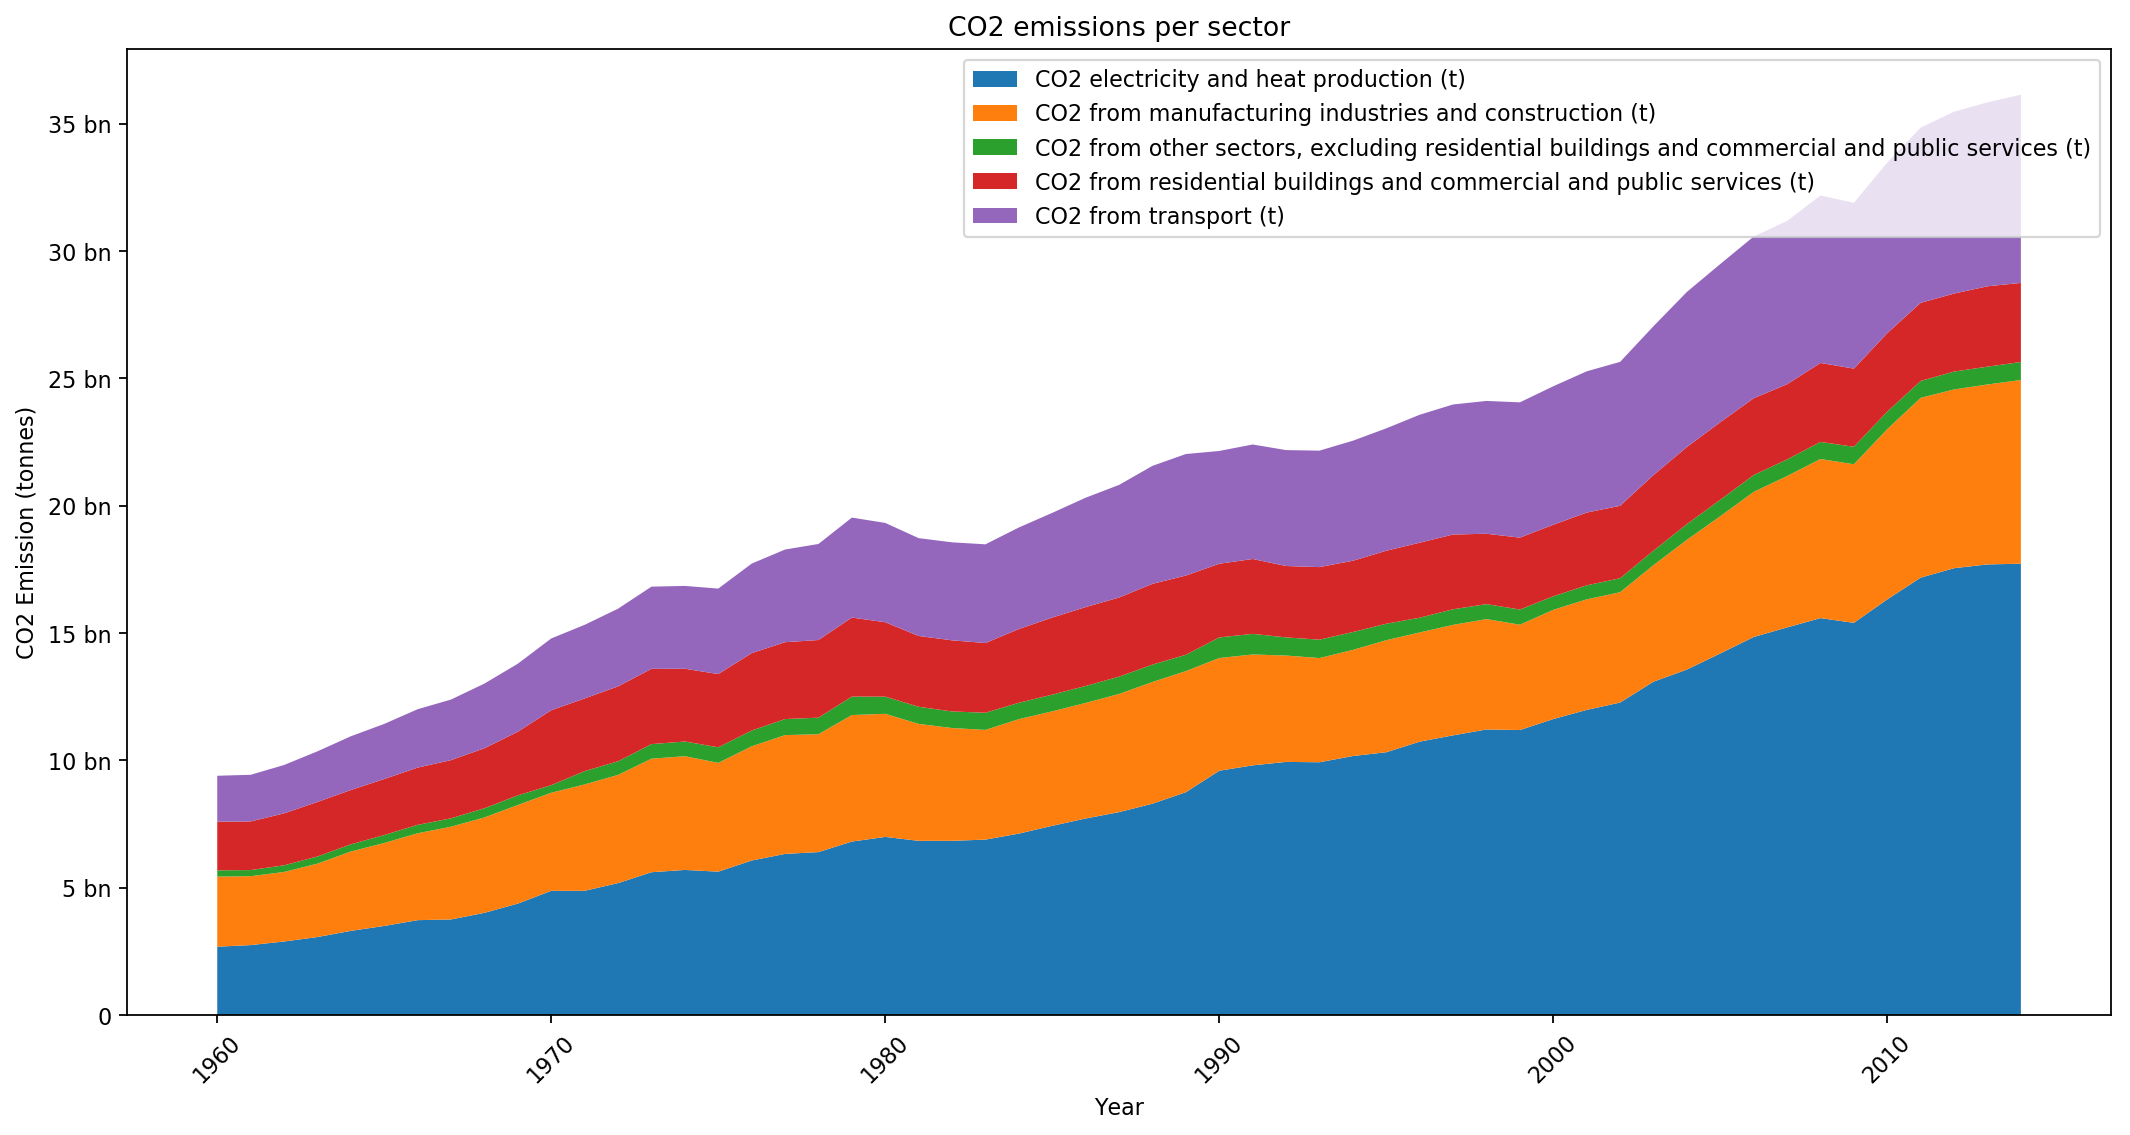

In [1068]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(16, 8), dpi=160)

data = df2[df2['country'] == 'World'].groupby(by='year').agg(
    {'CO2 electricity and heat production (t)':'sum',
     'CO2 from manufacturing industries and construction (t)':'sum',
     'CO2 from other sectors, excluding residential buildings and commercial and public services (t)':'sum',
     'CO2 from residential buildings and commercial and public services (t)':'sum',
     'CO2 from transport (t)':'sum'})

x=data.index
y1= data['CO2 electricity and heat production (t)']
y2= data['CO2 from manufacturing industries and construction (t)']
y3= data['CO2 from other sectors, excluding residential buildings and commercial and public services (t)']
y4= data['CO2 from residential buildings and commercial and public services (t)']
y5= data['CO2 from transport (t)']

ax = plt.subplot()
plt.stackplot(
    x,y1, y2, y3, y4, y5, 
    labels=[data.columns[0],data.columns[1],data.columns[2],data.columns[3],data.columns[4]])

ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('CO2 Emission (tonnes)')
plt.title('CO2 emissions per sector')
plt.legend(loc='upper right')
;

In [1069]:
(df2.query('year == 2014 & country == "World"').groupby(by='year').agg({'CO2 electricity and heat production (t)':'sum',
                                        'CO2 from manufacturing industries and construction (t)':'sum',
                                        'CO2 from other sectors, excluding residential buildings and commercial and public services (t)':'sum',
                                        'CO2 from residential buildings and commercial and public services (t)':'sum',
                                        'CO2 from transport (t)':'sum'}).reset_index() / df2.query('year == 1960 & country == "World"').groupby(by='year').agg({'CO2 electricity and heat production (t)':'sum',
                                        'CO2 from manufacturing industries and construction (t)':'sum',
                                        'CO2 from other sectors, excluding residential buildings and commercial and public services (t)':'sum',
                                        'CO2 from residential buildings and commercial and public services (t)':'sum',
                                        'CO2 from transport (t)':'sum'}).reset_index())
#calculating growth ratesd

,year,CO2 electricity and heat production (t),CO2 from manufacturing industries and construction (t),"CO2 from other sectors, excluding residential buildings and commercial and public services (t)",CO2 from residential buildings and commercial and public services (t),CO2 from transport (t)
0,1.027551,6.602737,2.6196,2.877456,1.624738,4.101873


### b, Correlation Matrix
<a id="threeb"></a>

In [1070]:
combined = pd.merge(nfa_year_country, df2, on=['country_code','year'], how='left')

In [1071]:
combined = pd.merge(combined, df2[['country_code','country']].drop_duplicates(),
                    on=['country_code'], how = 'left')

In [1072]:
combined['co2_per_capita_kt'] = combined['CO2 emissions (kt)'] / combined ['population']

In [1073]:
features = ['country','Access to clean fuels and technologies for cooking (% of population)',
 'co2_per_capita_kt', 'overshoot_rel',
 'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2011 PPP)',
 'GDP per capita, PPP (constant 2011 international $)',
 'Electricity production from coal sources (% of total)',
 'Electricity production from hydroelectric sources (% of total)',
 'Electricity production from natural gas sources (% of total)',
 'Electricity production from nuclear sources (% of total)',
 'Electricity production from oil sources (% of total)',
 'Electricity production from renewable sources, excluding hydroelectric (% of total)',
 'Electric power consumption (kWh per capita)']

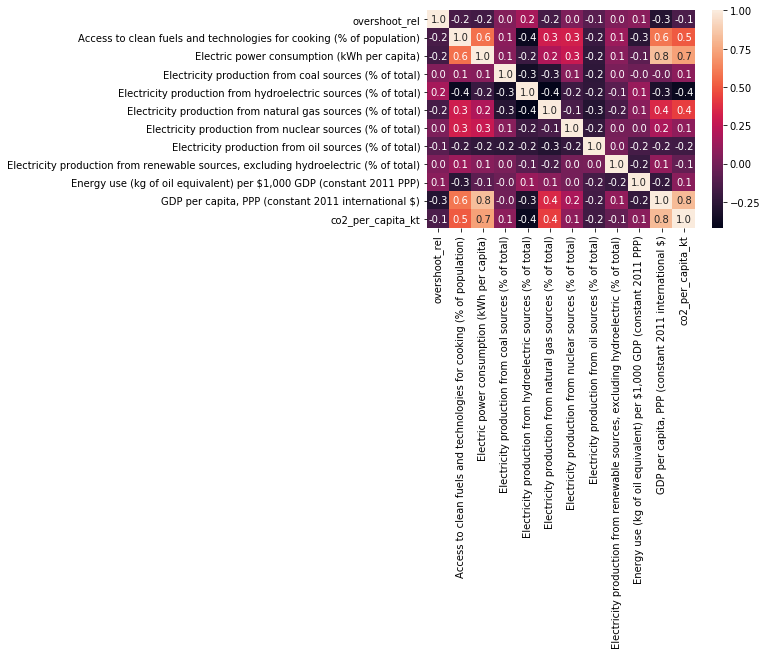

In [1074]:
sns.heatmap(combined[combined.query('year == 2014').columns.intersection(features)].dropna().corr(), annot=True, fmt=".1f")

### c, Relationship CO2 per Capita and GDP per Capita
<a id="threec"></a>

In [1088]:
scatter = combined.query('year == 2014')[['country','co2_per_capita_kt', 'CO2 emissions (kt)','GDP per capita, PPP (constant 2011 international $)']]

In [1089]:
scatter.dropna(inplace=True)

In [1090]:
combined.query(
    'year == 2014')[[
    'co2_per_capita_kt', 'GDP per capita, PPP (constant 2011 international $)']].corr()
#Calculating the correlation coefficient

,co2_per_capita_kt,"GDP per capita, PPP (constant 2011 international $)"
co2_per_capita_kt,1.000000,0.808537
"GDP per capita, PPP (constant 2011 international $)",0.808537,1.000000


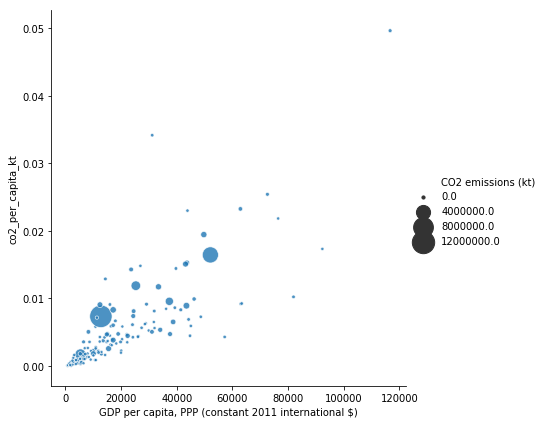

In [1077]:
sns.relplot(x='GDP per capita, PPP (constant 2011 international $)',
            y='co2_per_capita_kt',
            size= 'CO2 emissions (kt)',
            sizes=(10, 500),
            alpha=0.8,
            palette="muted",
            height=6,
            data=scatter)

### d, Energy Production by Type
<a id="threed"></a>

/Users/felixkoehler/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


<Figure size 2560x1280 with 0 Axes>

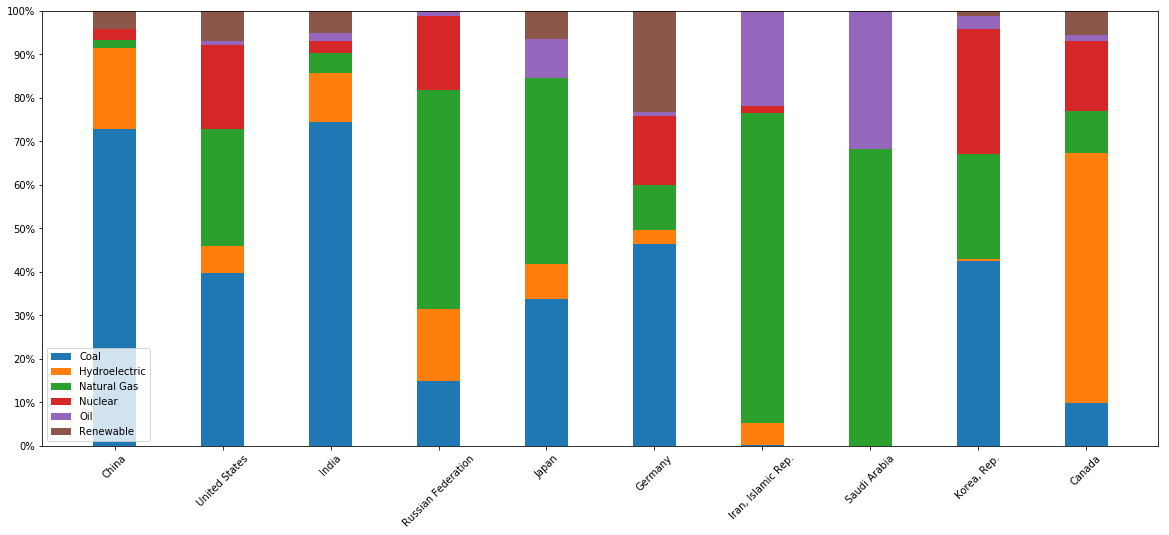

In [1078]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=160)

data = combined.query('year == 2014').sort_values(
    by='CO2 emissions (kt)',
    ascending=False).head(10)[[
    'country',
    'Electricity production from coal sources (% of total)',
    'Electricity production from hydroelectric sources (% of total)',
    'Electricity production from natural gas sources (% of total)',
    'Electricity production from nuclear sources (% of total)',
    'Electricity production from oil sources (% of total)',
    'Electricity production from renewable sources, excluding hydroelectric (% of total)'
]].reset_index()

N = list(data.country)
coal = data['Electricity production from coal sources (% of total)']
hydro = data['Electricity production from hydroelectric sources (% of total)']
gas = data['Electricity production from natural gas sources (% of total)']
atom = data['Electricity production from nuclear sources (% of total)']
oil = data['Electricity production from oil sources (% of total)']
renew = data['Electricity production from renewable sources, excluding hydroelectric (% of total)']
total = coal+hydro+gas+atom+oil+renew

ind = np.arange(10)    # the x locations for the groups
width = 0.4
# the width of the bars: can also be len(x) sequence
figure, ax = plt.subplots(figsize=(20,8))

plt.bar(ind, coal/total, width)
plt.bar(ind, hydro/total, width, bottom = coal/total)
plt.bar(ind, gas/total, width, bottom = (coal+hydro)/total)
plt.bar(ind, atom/total, width, bottom = (coal+hydro+gas)/total)
plt.bar(ind, oil/total, width, bottom = (coal+hydro+gas+atom)/total)
plt.bar(ind, renew/total, width, bottom = (coal+hydro+gas+atom+oil)/total)

#plt.xlabel('Year')
#plt.title('Biocapacity Debtors and Creditors over time')
plt.xticks(ind, data.country,rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(labels= ['Coal','Hydroelectric','Natural Gas','Nuclear','Oil','Renewable'],
           loc='bottom left')


ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Creditors', 'Debtors'))
#plt.figure(figsize=(20,8))